<a href="https://colab.research.google.com/github/ywang1110/NLP/blob/main/QuoraQuestionPairs_BERT_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Setup

In [2]:
!pip install -q tf-models-official==2.5.0  # Tensorflow offical models

[BERT in Keras with Tensorflow hub](https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf

# TensorFlow Hub is a repository of trained machine learning models ready for fine-tuning and deployable anywhere. 
# tensorflow_hub library lets you download and reuse them in your tensorflow program with a minimum amount of code
import tensorflow_hub as hub 

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# official models are a collection of models that use Tensorflow's high-level APIs
# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [4]:
print(tf.__version__)

2.5.0


In [5]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [6]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

## Data Preprocessing

## BERT Tokenizer

In [7]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


tokenize a question

In [8]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


### Encode the questions

The model expects its two inputs questions to be concatenated together. This input is expected to start with a [CLS] "This is a classification problem" token, and each question should end with a [SEP] "Separator" token:

In [9]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

**DataFrame.replace()**
* Parameters:
  1. to_replace:
  2. list og str, regex, numeric
  3. regex: Whether to interpret to_replace and/or value as regular expressions.If this is True then to_replace must be a string.
  4. inplace: If True, performs operation inplace and returns None. 


In [10]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [11]:
train_df = pd.read_csv('/content/gdrive/My Drive/NLP/Questions_pair_similiarity/train.csv')
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## Missing values

In [12]:
#Checking whether there are any rows with null values
df_miss = train_df[train_df.isnull().any(1)]
df_miss

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


question1 has 1 null object or missing value and question2 has 2 null objects or missing values.

#### Drop rows with null values

In [13]:
train_df.drop(df_miss.index, inplace=True)

In [14]:
train_df.shape

(404287, 6)

In [15]:

train_df["question1"][0]

'What is the step by step guide to invest in share market in india?'

In [16]:
tokenizer.tokenize(train_df["question1"][0])

['what',
 'is',
 'the',
 'step',
 'by',
 'step',
 'guide',
 'to',
 'invest',
 'in',
 'share',
 'market',
 'in',
 'india',
 '?']

In [17]:
# test truncating the number of tokens
tokenizer.tokenize(train_df["question1"][0])[:10]

['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in']

#### Ragged tensors
* They are the TENSORFLOW equivalent of **nested variable-length lists**
* They allow the storage and processing of **non-uniformly shaped data**
```
numbers = tf.ragged.constant([[8, 9, 3, 4], [], [1, 0], [-6], []])
words = tf.ragged.constant([['Hi', 'user'], ['thanks', 'for', 'the', 'keyboard', 'entries']])
```


In [18]:
# limit the number of tokens
# (it seems that some questions exist with a huge number of tokens)

max_tokens = 50

def encode_question(s):
   tokens = list(tokenizer.tokenize(s))[:max_tokens]
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)  
   # Converts a sequence of tokens (or just one) in a sequence of ids (or just one), using the vocabulary.


question1 = tf.ragged.constant([
    encode_question(s) for s in train_df["question1"]])

question2 = tf.ragged.constant([
    encode_question(s) for s in train_df["question2"]])

In [19]:
print("Question1 shape:", question1.shape.as_list())
print("Question2 shape:", question2.shape.as_list())

Question1 shape: [404287, None]
Question2 shape: [404287, None]


In [20]:
question1[0]

<tf.Tensor: shape=(16,), dtype=int32, numpy=
array([ 2054,  2003,  1996,  3357,  2011,  3357,  5009,  2000, 15697,
        1999,  3745,  3006,  1999,  2634,  1029,   102], dtype=int32)>

102 represents [SEP]

Now prepend a [CLS] token, and concatenate the ragged tensors to form a single input_word_ids tensor for each example. RaggedTensor.to_tensor() zero pads to the longest sequence.

**plt.pcolormesh([X, Y])**
* Create a **pseudocolor plot** with a non-regular rectangular grid

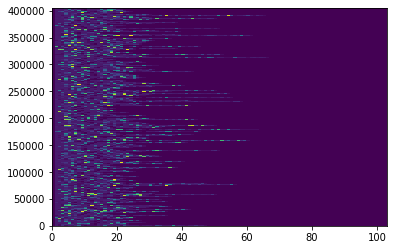

In [21]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*question1.shape[0]  # Constrcut the same dimensionality [CLS] with question 1 to prepend
input_word_ids = tf.concat([cls, question1, question2], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

In [22]:
type(input_word_ids)

tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor

In [23]:
type(input_word_ids.to_tensor())

tensorflow.python.framework.ops.EagerTensor

In [24]:
input_word_ids.numpy().shape

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/ragged/ragged_tensor.py:2053: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(rows)


(404287,)

## Mask and input type

The model expects **two additional inputs**:

* The input mask
* The input type

The mask allows the model to cleanly **differentiate** between the **content and the padding**. **The mask** has the **same shape** as the i**nput_word_ids**, and **contains a 1 anywhere** the input_word_ids is not padding.

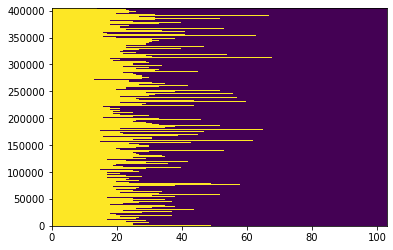

In [25]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

The "input type" also has the same shape, but inside the non-padded region, contains a 0 or a 1 indicating which sentence the token is a part of.

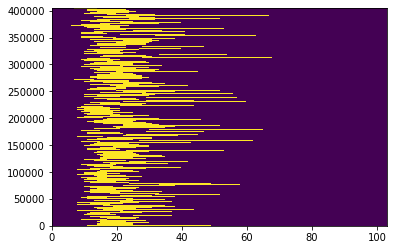

In [26]:
type_cls = tf.zeros_like(cls)      # Creates a tensor with all elements set to zero
type_s1 = tf.zeros_like(question1)
type_s2 = tf.ones_like(question2)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [27]:
import gc

# free up memory before proceeding
del question1
del question2
del input_word_ids
del cls
del input_mask
del type_cls
del type_s1
del type_s2
del input_type_ids
gc.collect()

2454

### Put it all together

Collect the above text parsing code into a single function, and apply it to each split of the dataset.

In [28]:
# limit the number of tokens
# (it seems that some questions exist with a huge number of tokens)
max_tokens = 50

def encode_question(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))[:max_tokens]
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(data_dict, tokenizer):
  num_examples = len(data_dict["question1"])
  
  question1 = tf.ragged.constant([
      encode_question(s, tokenizer)
      for s in np.array(data_dict["question1"])])
  question2 = tf.ragged.constant([
      encode_question(s, tokenizer)
       for s in np.array(data_dict["question2"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*question1.shape[0]
  input_word_ids = tf.concat([cls, question1, question2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(question1)
  type_s2 = tf.ones_like(question2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [29]:
# training \ validation split
from sklearn.model_selection import train_test_split

x_train, x_valid, train_labels, validation_labels = train_test_split(train_df,
                                                      train_df['is_duplicate'], 
                                                      test_size=0.3, 
                                                      stratify=train_df['is_duplicate'], 
                                                      random_state=0)

In [30]:
x_train.shape

(283000, 6)

In [31]:
x_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
149093,149093,234938,234939,How much do Uber drivers make in Houston?,How much does an Uber driver make in Houston o...,1
239294,239294,128118,206422,What are the movies that made you cry?,Which film/films made you cry? Don't forget to...,1
53929,53929,95260,95261,Why Delhi has high gun crime rates?,Why don't Jamia Millia Islamia's engineering c...,0
195713,195713,16462,82715,How can I improve my communication and verbal ...,How can you improve your communication skill?,1
80135,80135,110287,21840,Which is the best film?,What are the best movies of all time?,0


In [32]:
train_labels.shape

(283000,)

In [33]:
%%time
train = bert_encode(x_train, tokenizer)
validation = bert_encode(x_valid, tokenizer)

CPU times: user 3min 8s, sys: 585 ms, total: 3min 8s
Wall time: 3min 8s


Each subset of the data has been converted to a dictionary of features, and a set of labels. Each feature in the input dictionary has the same shape, and the number of labels should match:

In [34]:
train

{'input_mask': <tf.Tensor: shape=(283000, 103), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(283000, 103), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
 'input_word_ids': <tf.Tensor: shape=(283000, 103), dtype=int32, numpy=
 array([[  101,  2129,  2172, ...,     0,     0,     0],
        [  101,  2054,  2024, ...,     0,     0,     0],
        [  101,  2339,  6768, ...,     0,     0,     0],
        ...,
        [  101,  2097,  2111, ...,     0,     0,     0],
        [  101,  2129,  2116, ...,     0,     0,     0],
        [  101,  2003, 19739, ...,  

In [35]:
for key, value in train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'train_labels shape: {train_labels.shape}')

input_word_ids  shape: (283000, 103)
input_mask      shape: (283000, 103)
input_type_ids  shape: (283000, 103)
train_labels shape: (283000,)


In [36]:
train_labels

149093    1
239294    1
53929     0
195713    1
80135     0
         ..
278402    1
205379    0
252850    1
240291    0
77180     0
Name: is_duplicate, Length: 283000, dtype: int64

# The Model

download the configuration for pre-trained model

In [37]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

The config defines the core BERT Model, which is a Keras model to predict the outputs of num_classes from the inputs with maximum sequence length max_seq_length.

This function returns both the encoder and the classifier.

In [38]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model( bert_config, num_labels=2 )

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


The classifier has three inputs and one output:

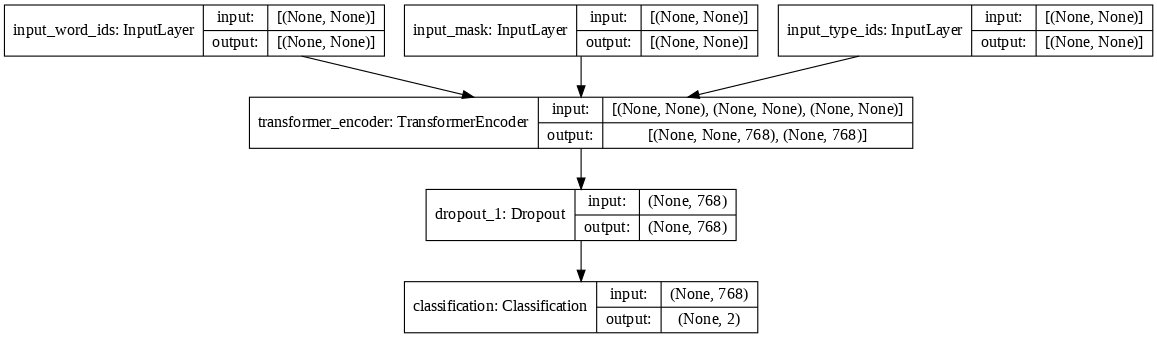

In [39]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=80)

In [40]:
bert_classifier.summary()

Model: "bert_classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder (Transforme [(None, None, 768),  109482240   input_word_ids[0][0]             
                                                                 input_mask[0][0]   

Run it on a test batch of data 10 examples from the training set. The output is the logits for the two classes:

In [41]:
data_batch = {key: val[:10] for key, val in train.items()}

bert_classifier(
    data_batch, training=True
).numpy()

array([[-0.2028877 ,  0.13556166],
       [-0.20839866,  0.46251246],
       [ 0.15906239,  0.21163711],
       [-0.08746268,  0.16786152],
       [-0.0818378 , -0.040961  ],
       [-0.09236995,  0.04454967],
       [ 0.04070425,  0.06013074],
       [-0.17317143,  0.11121346],
       [-0.17896399,  0.22426379],
       [-0.18505253,  0.15302056]], dtype=float32)

The TransformerEncoder in the center of the classifier above is the bert_encoder.

Inspecting the encoder, we see its stack of Transformer layers connected to those same three inputs:

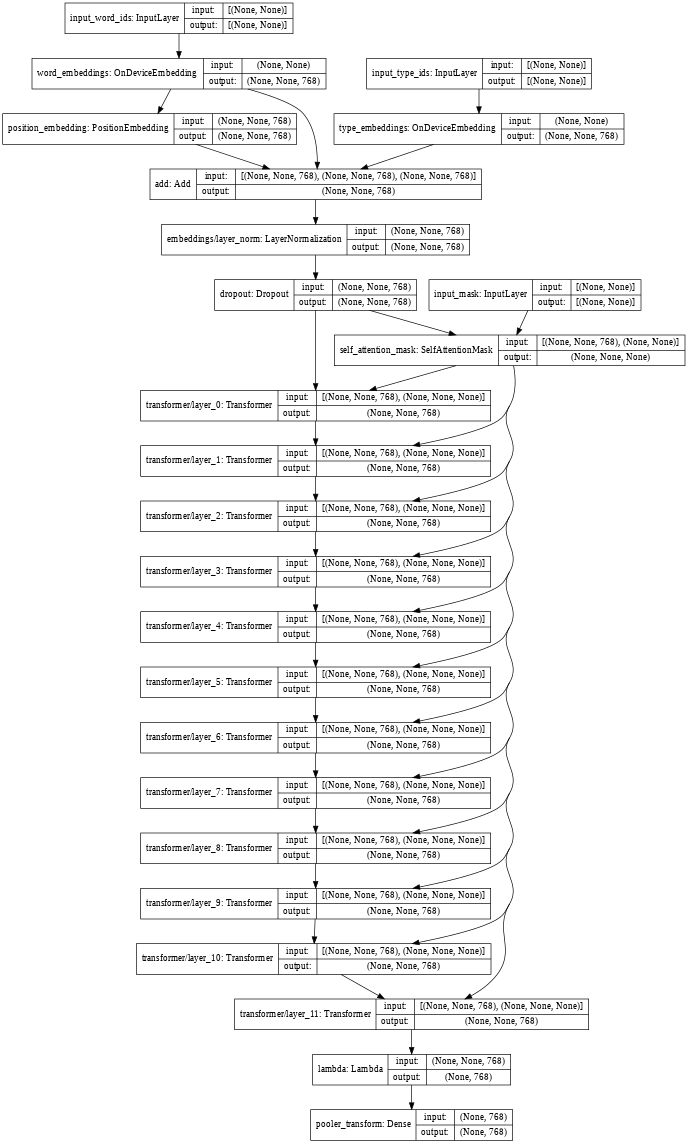

In [42]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

## Restore the encoder weights

When built the encoder is randomly initialized. Restore the encoder's weights from the checkpoint:

In [43]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

## Set up the optimizer

BERT adopts the Adam optimizer with weight decay (aka "AdamW"). It also employs a learning rate schedule that firstly warms up from 0 and then decays to 0.

In [44]:
# Set up epochs and steps
epochs = 4
batch_size = 16 # GPU recommend 16 | TPU recommend 32
eval_batch_size = 16

train_data_size = len(train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer( 2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps )

## Train the model

In [45]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

history = bert_classifier.fit( train, train_labels,
                               validation_data=(validation, validation_labels),
                               batch_size=batch_size,
                               epochs=epochs)

Epoch 1/4
17688/17688 [==============================] - 4116s 232ms/step - loss: 0.3383 - accuracy: 0.8443 - val_loss: 0.2592 - val_accuracy: 0.8894
Epoch 2/4
17688/17688 [==============================] - 4100s 232ms/step - loss: 0.2143 - accuracy: 0.9178 - val_loss: 0.2468 - val_accuracy: 0.9052
Epoch 3/4
17688/17688 [==============================] - 4108s 232ms/step - loss: 0.1511 - accuracy: 0.9530 - val_loss: 0.3291 - val_accuracy: 0.9087
Epoch 4/4
17688/17688 [==============================] - 4095s 232ms/step - loss: 0.1031 - accuracy: 0.9731 - val_loss: 0.4163 - val_accuracy: 0.9094


## Save the model

In [47]:
export_dir= base_dir + 'bert_model_2'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt 

def show_history( history ):

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_score = history.history['accuracy']
    val_score = history.history['val_accuracy']
    
    start = 1

    epochs = range(len(loss))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs[start:], loss[start:], 'bo', label='Training loss')
    plt.plot(epochs[start:], val_loss[start:], 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs[start:], train_score[start:], 'bo', label='Training accuracy')
    plt.plot(epochs[start:], val_score[start:], 'r', label='Validation accuracy')   
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    
    plt.tight_layout()
    plt.show() 

In [ ]:
# show the training graph
show_history( history ) 